#  Financial Planning

In [71]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [72]:
# Load .env enviroment variables
load_dotenv()
# check to see if the API key and secret are in the .env file
# os.environ['ALPACA_API_KEY']

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [73]:
# Set current amount of crypto assets
crypto_amounts = {
    'amounts': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
}
#set the assets owned
crypto_assets = ['BTC', 'ETH', 'DOT', 'ADA', 'XRP', 'DOGE', 'MATIC', 'SOL', 'UNI', 'ALGO', 'AVA']

#create an assets dataframe 
df_assets = pd.DataFrame(crypto_amounts, index=crypto_assets) #create a dataframe with the assets and amounts and set the index to the assets

#display the dataframe
df_assets

,amounts
BTC,1
ETH,1
DOT,1
ADA,1
XRP,1
DOGE,1
MATIC,1
SOL,1
UNI,1
ALGO,1


In [74]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"
dot_url = "https://api.alternative.me/v2/ticker/Polkadot/?convert=USD"
ada_url = "https://api.alternative.me/v2/ticker/Cardano/?convert=USD"
xrp_url = "https://api.alternative.me/v2/ticker/Ripple/?convert=USD"
doge_url = "https://api.alternative.me/v2/ticker/Dogecoin/?convert=USD"
matic_url = "https://api.alternative.me/v2/ticker/Matic-Network/?convert=USD"
sol_url = "https://api.alternative.me/v2/ticker/Solana/?convert=USD"
uni_url = "https://api.alternative.me/v2/ticker/Uniswap/?convert=USD"
algo_url = "https://api.alternative.me/v2/ticker/Algorand/?convert=USD"
ava_url = "https://api.alternative.me/v2/ticker/Avalanche-2/?convert=USD"

In [111]:
# Fetch current BTC price
btc_current_price = requests.get(btc_url).json()['data']['1']['quotes']['USD']['price'] #get the current price of BTC by using request.get and json to get the data and then the quotes and USD and price

# Fetch current ETH price
eth_current_price = requests.get(eth_url).json()['data']['1027']['quotes']['USD']['price'] #get the current price of ETH

# Fetch current DOT price
dot_current_price = requests.get(dot_url).json()['data']['11517']['quotes']['USD']['price'] #get the current price of DOT BY using request.get and json to get the data and then the quotes and USD and price.json() tells the computer to read the data as json, then ['11517'] tells the computer where in the dictionary to go next  

# Fetch current ADA price
ada_current_price = requests.get(ada_url).json()['data']['2010']['quotes']['USD']['price'] #get the current price of ADA

# Fetch current XRP price
xrp_current_price = requests.get(xrp_url).json()['data']['52']['quotes']['USD']['price'] #get the current price of XRP

# Fetch current DOGE price
doge_current_price = requests.get(doge_url).json()['data']['74']['quotes']['USD']['price'] #get the current price of DOGE

# Fetch current MATIC price
matic_current_price = requests.get(matic_url).json()['data']['0']['quotes']['USD']['price'] #get the current price of MATIC

# Fetch current SOL price
sol_current_price = requests.get(sol_url).json()['data']['11733']['quotes']['USD']['price'] #get the current price of SOL

# Fetch current UNI price
uni_current_price = requests.get(uni_url).json()['data']['11968']['quotes']['USD']['price'] #get the current price of UNI

# Fetch current ALGO price
algo_current_price = requests.get(algo_url).json()['data']['0']['quotes']['USD']['price'] #get the current price of ALGO

# Fetch current AVA price
#ava_current_price = requests.get(ava_url).json()['data']['10237']['quotes']['USD']['price'] #get the current price of AVA


# Compute current value of my crpto
my_btc = df_assets.loc['BTC', 'amounts']  #get the amount of BTC from the dataframe
my_eth = df_assets.loc['ETH', 'amounts'] #get the amount of ETH from the dataframe
my_dot = df_assets.loc['DOT', 'amounts'] #get the amount of DOT from the dataframe
my_ada = df_assets.loc['ADA', 'amounts'] #get the amount of ADA from the dataframe
my_xrp = df_assets.loc['XRP', 'amounts'] #get the amount of XRP from the dataframe
my_doge = df_assets.loc['DOGE', 'amounts'] #get the amount of DOGE from the dataframe
my_matic = df_assets.loc['MATIC', 'amounts'] #get the amount of MATIC from the dataframe
my_sol = df_assets.loc['SOL', 'amounts'] #get the amount of SOL from the dataframe
my_uni = df_assets.loc['UNI', 'amounts'] #get the amount of UNI from the dataframe
my_algo = df_assets.loc['ALGO', 'amounts'] #get the amount of ALGO from the dataframe
#my_ava = df_assets.loc['AVA', 'amounts'] #get the amount of AVA from the dataframe



my_btc_value = btc_current_price * df_assets.loc['BTC', 'amounts'] #compute the value of BTC
my_eth_value = eth_current_price * df_assets.loc['ETH', 'amounts'] #compute the value of ETH
my_dot_value = dot_current_price * df_assets.loc['DOT', 'amounts'] #compute the value of DOT
my_ada_value = ada_current_price * df_assets.loc['ADA', 'amounts'] #compute the value of ADA
my_xrp_value = xrp_current_price * df_assets.loc['XRP', 'amounts'] #compute the value of XRP
my_doge_value = doge_current_price * df_assets.loc['DOGE', 'amounts'] #compute the value of DOGE
my_matic_value = matic_current_price * df_assets.loc['MATIC', 'amounts'] #compute the value of MATIC
my_sol_value = sol_current_price * df_assets.loc['SOL', 'amounts'] #compute the value of SOL
my_uni_value = uni_current_price * df_assets.loc['UNI', 'amounts'] #compute the value of UNI
my_algo_value = algo_current_price * df_assets.loc['ALGO', 'amounts'] #compute the value of ALGO
#my_ava_value = ava_current_price * df_assets.loc['AVA', 'amounts'] #compute the value of AVA


# Print current crypto wallet balance
portfolio_value = my_btc_value + my_eth_value #compute the value of the portfolio
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")
print(f"The current value of your {my_dot} DOT is ${my_dot_value:0.2f}")
print(f"The current value of your {my_ada} ADA is ${my_ada_value:0.2f}")
print(f"The current value of your {my_xrp} XRP is ${my_xrp_value:0.2f}")
print(f"The current value of your {my_doge} DOGE is ${my_doge_value:0.2f}")
print(f"The current value of your {my_matic} MATIC is ${my_matic_value:0.2f}")
print(f"The current value of your {my_sol} SOL is ${my_sol_value:0.2f}")
print(f"The current value of your {my_uni} UNI is ${my_uni_value:0.2f}")
print(f"The current value of your {my_algo} ALGO is ${my_algo_value:0.2f}")
#print(f"The current value of your {my_ava} AVA is ${my_ava_value:0.2f}")
print(f' Total portfolio value in USD = ${portfolio_value}')

The current value of your 1 BTC is $19398.66
The current value of your 1 ETH is $1308.06
The current value of your 1 DOT is $6.14
The current value of your 1 ADA is $0.37
The current value of your 1 XRP is $0.47
The current value of your 1 DOGE is $0.06
The current value of your 1 MATIC is $0.85
The current value of your 1 SOL is $30.24
The current value of your 1 UNI is $6.46
The current value of your 1 ALGO is $0.32
 Total portfolio value in USD = $20706.72


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [76]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [77]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY") #get the API key from the .env file
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(alpaca_api_key,  # API key
    alpaca_secret_key, 
    api_version='v2'
)


In [78]:
# Format current date as ISO format
#today = pd.to_datetime('today').isoformat()
today = pd.Timestamp("2022-04-06", tz = "America/New_York").isoformat() #add timestamp to get the current date at eastern time

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
df_stock_portfolio = alpaca.get_bars( #get the current closing prices for the stocks in the portfolio
    tickers,
    timeframe,
    start = today,
    end = today,
).df
df_stock_portfolio


,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2022-04-06 04:00:00+00:00,105.20,105.805,105.115,105.49,12763945,47018,105.461369,AGG
2022-04-06 04:00:00+00:00,446.87,448.930,443.470,446.52,104761415,892577,446.339985,SPY


In [79]:

df_stock_portfolio = df_stock_portfolio[['symbol', 'open', 'high', 'low', 'close', 'volume', 'vwap']] #create a new dataframe with the columns in the order that we want them to be
df_stock_portfolio

,symbol,open,high,low,close,volume,vwap
timestamp,,,,,,,
2022-04-06 04:00:00+00:00,AGG,105.20,105.805,105.115,105.49,12763945,105.461369
2022-04-06 04:00:00+00:00,SPY,446.87,448.930,443.470,446.52,104761415,446.339985


In [80]:
# Reorganize the DataFrame
# Separate ticker data
AGG = df_stock_portfolio[df_stock_portfolio['symbol']=='AGG'].drop('symbol', axis=1) # drop the ticker column from the dataframe and assign it to a new variable
SPY = df_stock_portfolio[df_stock_portfolio['symbol']=='SPY'].drop('symbol', axis=1) # drop the ticker column and rename the column
df_stock_portfolio



,symbol,open,high,low,close,volume,vwap
timestamp,,,,,,,
2022-04-06 04:00:00+00:00,AGG,105.20,105.805,105.115,105.49,12763945,105.461369
2022-04-06 04:00:00+00:00,SPY,446.87,448.930,443.470,446.52,104761415,446.339985


In [81]:

# Concatenate the ticker DataFrames
df_stock_portfolio = pd.concat([AGG, SPY], axis = 1, keys=['AGG', 'SPY']) #concatenate the ticker dataframes

# Preview DataFrame
df_stock_portfolio

AGG                                      \
                            open     high      low   close    volume   
timestamp                                                              
2022-04-06 04:00:00+00:00  105.2  105.805  105.115  105.49  12763945   

                                          SPY                          \
                                 vwap    open    high     low   close   
timestamp                                                               
2022-04-06 04:00:00+00:00  105.461369  446.87  448.93  443.47  446.52   

                                                  
                              volume        vwap  
timestamp                                         
2022-04-06 04:00:00+00:00  104761415  446.339985

In [82]:
# Pick AGG and SPY close prices
agg_close_price = float(df_stock_portfolio['AGG']['close']) # get the close price for AGG and cast it as a float so that we can perform arithmetic operations on it
spy_close_price = float(df_stock_portfolio['SPY']['close']) # get the close price for AGG and cast it as a float so that we can perform arithmetic operations on it


# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}") 
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $105.49
Current SPY closing price: $446.52


In [83]:
# Compute the current value of shares
my_agg_value = agg_close_price * my_agg
my_spy_value = spy_close_price * my_spy

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value}")

The current value of your 50 SPY shares is $22326.0
The current value of your 200 AGG shares is $21098.0


### Savings Health Analysis

In [84]:
# Set monthly household income
monthly_income = 100000


# Consolidate financial assets data
total_crypto = my_btc_value + my_eth_value # add the two values together
total_stock = my_spy_value + my_agg_value 
indices = ['total crypto', 'total stock'] # create a list of the indices
df_assets_dict = {'$amounts': [total_crypto, total_stock]} # create a dictionary of the total crypto and total stock
df_assets_dict
# Create savings DataFrame
df_savings = pd.DataFrame(df_assets_dict, index=indices) # create a dataframe with the dictionary and the indices specified above

# Display savings DataFrame
display(df_savings)

,$amounts
total crypto,20706.72
total stock,43424.00


array([<AxesSubplot:ylabel='$amounts'>], dtype=object)

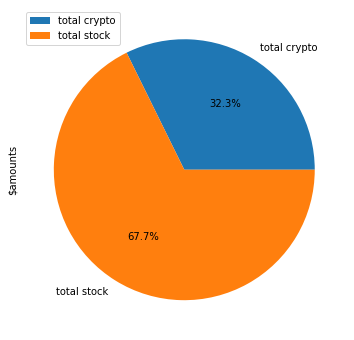

In [85]:
# Plot savings pie chart
df_savings.plot.pie(subplots=True, autopct='%1.1f%%', figsize=(6, 6)) # plot the pie chart with the specified parameters

In [86]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = df_savings.loc['total stock', '$amounts'] + df_savings.loc['total crypto', '$amounts'] + emergency_fund # add the three values together
total_savings
# Validate saving health
if total_savings > emergency_fund: # if the total savings is greater than the emergency fund then print the following
    print(f"you have a healthy saving of ${total_savings}")
elif total_savings == emergency_fund:
    print(f"you have a healthy saving of ${total_savings}")
else:
    print(f"you have a unhealthy saving of ${total_savings}")
  

you have a healthy saving of $364130.72


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [87]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-05-01', tz='America/New_York').isoformat() # set the start date to the first day of May 2016
end_date = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat() # set the end date to the first day of May 2021

In [88]:
# Get 5 years' worth of historical data for SPY and AGG
df_stock_history = alpaca.get_bars( #get the current closing prices for the stocks in the portfolio
    tickers,
    timeframe,
    start = start_date,
    end = end_date,
).df

# Reorganize the DataFrame
# Separate ticker data
# Reorganize the DataFrame
# Separate ticker data
AGG = df_stock_history[df_stock_history['symbol']=='AGG'].drop('symbol', axis=1) # drop the ticker column from the dataframe and assign it to a new variable
SPY = df_stock_history[df_stock_history['symbol']=='SPY'].drop('symbol', axis=1) # drop the ticker column and rename the column

# Concatenate the ticker DataFrames
df_stock_history = pd.concat([AGG, SPY], axis = 1, keys=['AGG', 'SPY'])

# Display sample data
df_stock_history.head()

AGG                                       \
                             open      high       low   close   volume   
timestamp                                                                
2016-05-02 04:00:00+00:00  110.74  110.7400  110.5200  110.61  3553939   
2016-05-03 04:00:00+00:00  110.89  110.9450  110.7500  110.81  3044940   
2016-05-04 04:00:00+00:00  110.91  110.9315  110.7595  110.86  2920608   
2016-05-05 04:00:00+00:00  110.92  111.1600  110.8010  111.14  3008142   
2016-05-06 04:00:00+00:00  111.12  111.1200  110.9700  110.97  2718710   

                                                      SPY                  \
                          trade_count        vwap    open    high     low   
timestamp                                                                   
2016-05-02 04:00:00+00:00       15119  110.627199  206.90  208.18  206.41   
2016-05-03 04:00:00+00:00       15662  110.865995  206.50  206.80  205.28   
2016-05-04 04:00:00+00:00       13982  110.879063  205.00  205.85  204.42   
2016-05-05 04:00:00+00:00       15707  111.028363  205.57  205.98  204.47   
2016-05-06 04:00:00+00:00       12697  111.031967  204.04  205.77  203.88   

                                                                      
                            close     volume trade_count        vwap  
timestamp                                                             
2016-05-02 04:00:00+00:00  208.03   61908515      263580  207.294812  
2016-05-03 04:00:00+00:00  206.13  106422142      377518  206.312060  
2016-05-04 04:00:00+00:00  204.96   92199810      345261  205.090172  
2016-05-05 04:00:00+00:00  204.95   67597222      280622  205.141555  
2016-05-06 04:00:00+00:00  205.70   89131004      340335  204.937074

In [89]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_fiveyear = MCSimulation( #create a Monte Carlo simulation object
    portfolio_data = df_stock_history,
    weights= [.4, .6],
    num_simulation = 100,
    num_trading_days= 252*30,
)

In [90]:
# Printing the simulation input data
MC_fiveyear.portfolio_data.head()

AGG                                       \
                             open      high       low   close   volume   
timestamp                                                                
2016-05-02 04:00:00+00:00  110.74  110.7400  110.5200  110.61  3553939   
2016-05-03 04:00:00+00:00  110.89  110.9450  110.7500  110.81  3044940   
2016-05-04 04:00:00+00:00  110.91  110.9315  110.7595  110.86  2920608   
2016-05-05 04:00:00+00:00  110.92  111.1600  110.8010  111.14  3008142   
2016-05-06 04:00:00+00:00  111.12  111.1200  110.9700  110.97  2718710   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2016-05-02 04:00:00+00:00       15119  110.627199          NaN  206.90   
2016-05-03 04:00:00+00:00       15662  110.865995     0.001808  206.50   
2016-05-04 04:00:00+00:00       13982  110.879063     0.000451  205.00   
2016-05-05 04:00:00+00:00       15707  111.028363     0.002526  205.57   
2016-05-06 04:00:00+00:00       12697  111.031967    -0.001530  204.04   

                                                                          \
                             high     low   close     volume trade_count   
timestamp                                                                  
2016-05-02 04:00:00+00:00  208.18  206.41  208.03   61908515      263580   
2016-05-03 04:00:00+00:00  206.80  205.28  206.13  106422142      377518   
2016-05-04 04:00:00+00:00  205.85  204.42  204.96   92199810      345261   
2016-05-05 04:00:00+00:00  205.98  204.47  204.95   67597222      280622   
2016-05-06 04:00:00+00:00  205.77  203.88  205.70   89131004      340335   

                                                    
                                 vwap daily_return  
timestamp                                           
2016-05-02 04:00:00+00:00  207.294812          NaN  
2016-05-03 04:00:00+00:00  206.312060    -0.009133  
2016-05-04 04:00:00+00:00  205.090172    -0.005676  
2016-05-05 04:00:00+00:00  205.141555    -0.000049  
2016-05-06 04:00:00+00:00  204.937074     0.003659

In [91]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
results = MC_fiveyear.calc_cumulative_return()# run the Monte Carlo simulation

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


In [92]:
results.to_csv('MC_30year_sim_results.csv') # I know this was not specifically requested in this assignment, however, I wanted to save the results to a csv file for my own curiosity

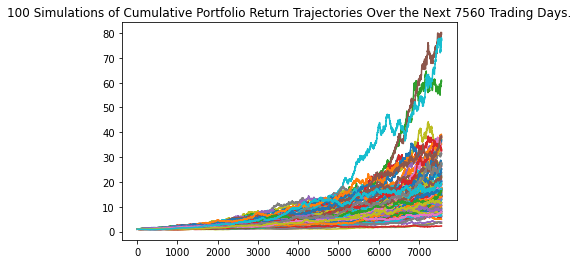

In [93]:
# Plot simulation outcomes
line_plot = MC_fiveyear.plot_simulation()
        

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 100 Simulations'}, ylabel='Frequency'>

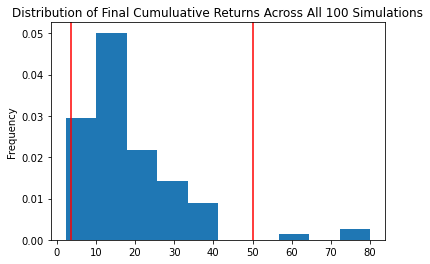

In [94]:
# Plot probability distribution and confidence intervals
MC_fiveyear.plot_distribution()

### Retirement Analysis

In [95]:
# Fetch summary statistics from the Monte Carlo simulation results
mc_summary = MC_fiveyear.summarize_cumulative_return()

# Print summary statistics
mc_summary

count           100.000000
mean             18.904742
std              13.066337
min               2.296037
25%              10.681590
50%              16.464192
75%              22.753355
max              80.054433
95% CI Lower      3.668357
95% CI Upper     50.034355
Name: 7560, dtype: float64

### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [96]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_upper = round(mc_summary[9]*initial_investment, 2) # create variable for the upper confidence interval and round it to two decimal places
ci_lower = round(mc_summary[8]*initial_investment, 2) # create variable for the lower confidence interval and round it to two decimal places

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $73367.14 and $1000687.11


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [97]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_upper = round(mc_summary[9]*initial_investment, 2) # create variable for the upper confidence interval and round it to two decimal places
ci_lower = round(mc_summary[8]*initial_investment, 2) # create variable for the lower confidence interval and round it to two decimal places

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $110050.71 and $1501030.66


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [98]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_fiveyear = MCSimulation( #create a Monte Carlo simulation object
    portfolio_data = df_stock_history,
    weights= [.4, .6],
    num_simulation = 100,
    num_trading_days= 252*5,
)

In [99]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_fiveyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.005200,1.008144,1.004274,1.003862,1.010171,1.000578,1.010082,0.992338,1.008051,1.008497,...,1.010302,0.999617,0.997110,1.001727,0.991886,0.995201,0.995300,1.004955,0.989395,0.999321
2,1.003878,1.002767,1.020440,0.999861,1.020410,1.008372,1.004471,0.987220,1.026797,1.004998,...,1.008377,1.007967,1.004023,0.999112,0.992355,0.998352,1.005946,1.006430,0.988265,1.006357
3,1.016535,1.001046,1.012073,1.007915,1.026367,1.013783,1.005792,0.975747,1.034988,1.011644,...,0.998441,1.016002,1.010035,1.010325,0.994655,1.007140,1.015997,1.009382,0.985521,1.015789
4,1.018510,0.999353,1.006611,1.000335,1.025666,1.019439,1.010744,0.966579,1.043514,1.002559,...,0.998976,0.993899,1.015817,1.010066,0.999036,1.015388,1.008695,1.007047,0.988559,1.003391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,2.252658,1.963701,2.631204,1.579878,1.216093,1.564204,1.861946,1.062725,2.376041,1.580295,...,1.350511,1.144613,1.757475,2.037171,2.742797,1.516550,2.062062,1.577251,1.473814,1.235958
1257,2.267533,1.970016,2.633836,1.573300,1.205889,1.578581,1.863173,1.046419,2.369295,1.580846,...,1.339917,1.154748,1.756645,2.045269,2.757754,1.511436,2.085875,1.575108,1.453371,1.244023
1258,2.275974,1.978774,2.645325,1.590659,1.212235,1.562523,1.868172,1.056157,2.351066,1.572310,...,1.350230,1.137367,1.731337,2.053971,2.770892,1.504842,2.103687,1.570612,1.458167,1.244246
1259,2.245902,1.962198,2.663195,1.573076,1.209496,1.560602,1.852368,1.058970,2.365075,1.564068,...,1.352955,1.138746,1.726443,2.054256,2.767412,1.493329,2.106667,1.562530,1.473827,1.251415


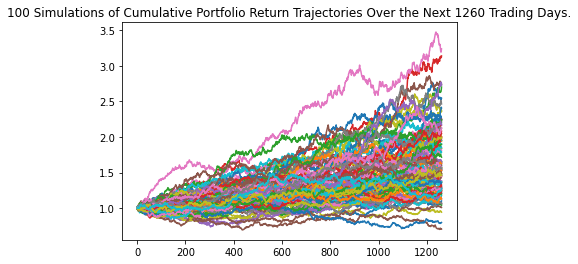

In [100]:
# Plot simulation outcomes
line_plot_5year = MC_fiveyear.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 100 Simulations'}, ylabel='Frequency'>

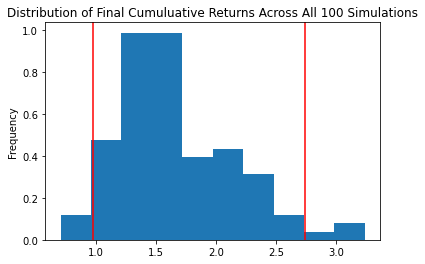

In [101]:
# Plot probability distribution and confidence intervals
MC_fiveyear.plot_distribution()

In [102]:
# Fetch summary statistics from the Monte Carlo simulation results
mc_summary_five_year = MC_fiveyear.summarize_cumulative_return()

# Print summary statistics
mc_summary_five_year

count           100.000000
mean              1.655146
std               0.492846
min               0.706125
25%               1.282228
50%               1.553317
75%               1.957666
max               3.237029
95% CI Lower      0.975099
95% CI Upper      2.735325
Name: 1260, dtype: float64

In [103]:
# Set initial investment
initial_investment_five_year = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_upper_five = round(mc_summary_five_year[9]*initial_investment_five_year, 2) # create variable for the upper confidence interval and round it to two decimal places
ci_lower_five = round(mc_summary_five_year[8]*initial_investment_five_year, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_five_year} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $58505.91 and $164119.5


### Ten Years Retirement Option

In [104]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_fiveyear = MCSimulation(
    portfolio_data=df_stock_history, 
    weights=(.4, .6),
    num_simulation=100,
    num_trading_days=252*10
)

In [105]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_fiveyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.990512,1.004435,0.997461,1.000097,1.011644,1.006886,0.996971,0.992734,1.004606,1.014217,...,1.005690,0.998854,1.004729,1.007523,1.005994,1.009387,1.009887,1.002752,0.999280,1.005567
2,0.995720,1.001572,0.997440,1.010372,1.003930,1.016466,0.989312,0.993258,1.010189,1.015810,...,1.017074,0.984105,0.991725,1.009844,0.993542,1.001167,1.000960,1.001916,1.004733,1.012385
3,1.007591,1.011915,1.003017,1.014420,1.006650,1.024419,1.002183,0.998199,1.014387,1.019076,...,1.021449,0.980796,0.991385,0.996759,0.991079,0.995321,0.994500,1.004061,1.017322,1.020141
4,1.012897,1.007246,0.999204,1.003623,0.997866,1.027211,1.005325,0.996874,1.015947,1.012109,...,1.019934,0.988602,1.002475,1.000441,0.994350,0.997439,0.991256,1.009270,1.010770,1.031947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,3.077368,2.195174,2.258989,2.193795,1.884904,4.018922,3.622096,2.684623,2.157526,4.855037,...,4.001836,2.220880,3.282419,1.806868,1.862754,4.804471,3.101958,1.975913,4.393918,2.761287
2517,3.098936,2.187929,2.256334,2.208302,1.862401,3.948417,3.605174,2.672061,2.161028,4.869447,...,3.999440,2.219865,3.304287,1.787751,1.866852,4.842420,3.096092,1.977183,4.379197,2.772749
2518,3.096775,2.173225,2.252013,2.207083,1.858424,3.908031,3.577352,2.687490,2.178417,4.873444,...,3.987762,2.203179,3.343014,1.781544,1.870634,4.869844,3.081436,1.973899,4.399930,2.772727
2519,3.109232,2.176176,2.254287,2.230023,1.848805,3.898351,3.647660,2.695372,2.201572,4.860292,...,4.018350,2.181095,3.318793,1.765540,1.890332,4.896891,3.067983,1.959241,4.439486,2.818351


<AxesSubplot:title={'center':'100 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days.'}>

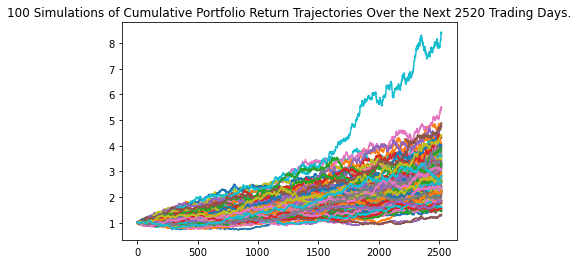

In [106]:
# Plot simulation outcomes
MC_fiveyear.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 100 Simulations'}, ylabel='Frequency'>

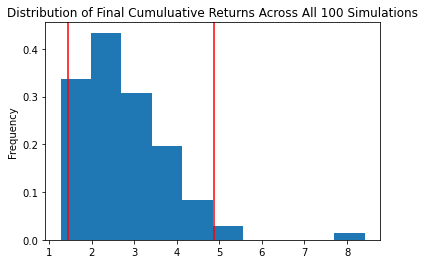

In [107]:
# Plot probability distribution and confidence intervals
MC_fiveyear.plot_distribution()

In [108]:
# Fetch summary statistics from the Monte Carlo simulation results
mc_summary_10_year = MC_fiveyear.summarize_cumulative_return()
# Print summary statistics
mc_summary_10_year

count           100.000000
mean              2.802696
std               1.093960
min               1.270909
25%               2.105096
50%               2.599161
75%               3.331931
max               8.418079
95% CI Lower      1.448628
95% CI Upper      4.865287
Name: 2520, dtype: float64

In [109]:
# Set initial investment
initial_investment_10_year = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_upper_ten = round(mc_summary_10_year[9]*initial_investment_10_year, 2) # create variable for the upper confidence interval and round it to two decimal places. [9] tells python to use the 9th result down. CI upper is the 9th place down in the summary 
ci_lower_ten = round(mc_summary_10_year[8]*initial_investment_10_year, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_10_year} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $86917.69 and $291917.23


In [110]:
mean = round(mc_summary_10_year[1]*initial_investment_10_year)
print(f'the mean return for the initial investment of ${initial_investment_10_year} in the portfolio is ${mean}')

the mean return for the initial investment of $60000 in the portfolio is $168162
